使用DCGAN生成Cifar10数据
===

# 1.全局设置

In [12]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = '/input/'
IMAGE_CHANNEL = 3
IMAGE_SIZE = 32
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
NOISE_DIM = 100
EPOCH = 100

In [13]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, torch.nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            # m.bias.data.zero_()
        elif isinstance(m, torch.nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            # m.bias.data.zero_()
        elif isinstance(m, torch.nn.Linear):
            m.weight.data.normal_(0, 0.02)
            # m.bias.data.zero_()


# 2.模型

In [14]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.module1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 64 * 4, 4, 2, 0, bias=False),
            torch.nn.BatchNorm2d(64 * 4),
            torch.nn.ReLU(True)
        )

        self.module2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.ReLU(True)
        )

        self.module3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(True)
        )

        self.module4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        initialize_weights(self)

    def forward(self, x):
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)

        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.module1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 64, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.module2 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 2),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.module3 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(64 * 4),
            torch.nn.LeakyReLU(negative_slope=0.2, inplace=False)
        )

        self.module4 = torch.nn.Sequential(
            torch.nn.Conv2d(64 * 4, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

        initialize_weights(self)

    def forward(self, x):
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)

        return x

# 3.导入数据

In [17]:
trans = tv.transforms.Compose([tv.transforms.ToTensor()])

NetG = Generator()
NetD = Discriminator()
criterion = torch.nn.BCELoss()
fix_noise_var = torch.autograd.Variable(torch.FloatTensor(BATCH_SIZE, NOISE_DIM, 1, 1).normal_(0, 1))
if torch.cuda.is_available():
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    fix_noise_var = fix_noise_var.cuda()
    criterion.cuda()

train_dataset = tv.datasets.CIFAR10(root=DATA_PATH, 
                                 train=True, 
                                 transform=trans,
                                 download=True)
train_loader=torch.utils.data.DataLoader(train_dataset,BATCH_SIZE,shuffle = True)

optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

Files already downloaded and verified


# 4.训练

In [18]:
bar = bar.ProgressBar(EPOCH, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    if epoch % 30 == 0:
        optimizerD.param_groups[0]['lr'] /= 10
        optimizerG.param_groups[0]['lr'] /= 10

    for ii, data in enumerate(train_loader,0):
        input,_=data

        input = torch.autograd.Variable(input)
        label = torch.ones(input.size(0))
        label = torch.autograd.Variable(label)
        noise = torch.randn(input.size(0),NOISE_DIM,1,1)
        noise = torch.autograd.Variable(noise)

        if torch.cuda.is_available():
            input = input.cuda()
            label = label.cuda()
            noise = noise.cuda()

        NetD.zero_grad()
        output=NetD(input)
        error_real=criterion(output.squeeze(),label)
        error_real.backward()

        D_x=output.data.mean()
        fake_pic=NetG(noise).detach()
        output2=NetD(fake_pic)
        label.data.fill_(0) # 0 for fake
        error_fake=criterion(output2.squeeze(),label)

        error_fake.backward()
        D_x2=output2.data.mean()
        error_D=error_real+error_fake
        optimizerD.step()

        NetG.zero_grad()
        label.data.fill_(1)
        noise.data.normal_(0,1)
        fake_pic=NetG(noise)
        output=NetD(fake_pic)
        error_G=criterion(output.squeeze(),label)
        error_G.backward()

        optimizerG.step()
        D_G_z2=output.data.mean()
        bar.show(epoch, error_D.item(), error_G.item())

Epoch:1 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.673;G Loss:3.832,total=0:00:2908
Epoch:2 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.399;G Loss:2.622,total=0:00:280
Epoch:3 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.563;G Loss:2.958,total=0:00:280
Epoch:4 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.755;G Loss:0.758,total=0:00:280
Epoch:5 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.531;G Loss:1.596,total=0:00:28022:57
Epoch:6 / 100 [*******************************************************************************

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:86 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.170;G Loss:3.736,total=0:00:280
Epoch:87 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.183;G Loss:4.343,total=0:00:280:52:320
Epoch:88 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.115;G Loss:3.611,total=0:00:280:09:4827
Epoch:89 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.081;G Loss:3.360,total=0:00:280:15:4778
Epoch:90 / 100 [***********************                                                                                        ] 164 / 782 ,D Loss:0.119;G Loss:3.724,remain=2:40:55:32:2175

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:92 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.196;G Loss:3.152,total=0:00:290
Epoch:93 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.101;G Loss:3.633,total=0:00:280:14:2713
Epoch:94 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.223;G Loss:2.437,total=0:00:280:30:111
Epoch:95 / 100 [*************************************************************************************************              ] 679 / 782 ,D Loss:0.179;G Loss:3.579,remain=0:06:53:45:515

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch:97 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.287;G Loss:3.555,total=0:00:280
Epoch:98 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.098;G Loss:4.105,total=0:00:280:27:2226
Epoch:99 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.110;G Loss:3.443,total=0:00:280:42:2818
Epoch:100 / 100 [***************************************************************************************************************] 782 / 782 ,D Loss:0.155;G Loss:2.869,total=0:00:280:57:3209


# 5.生成图像

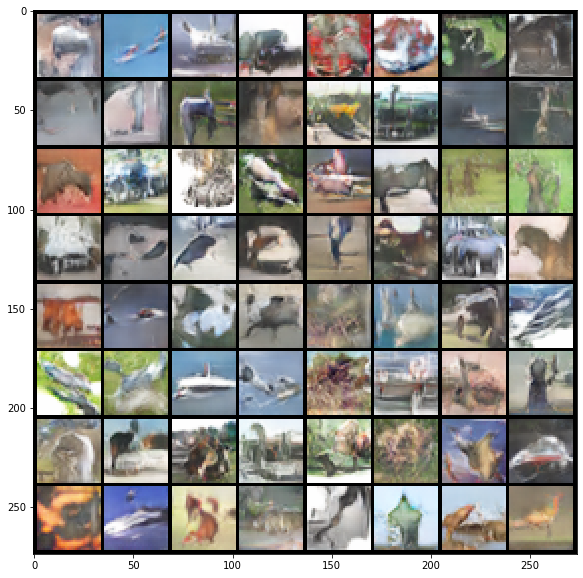

In [22]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:64], nrow=8, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))